## Import Libraries and Data

In [5]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_03-06-04-23.csv', firstRow=270, lastRow=276)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_040423_S271-276.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [6]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=76s and ended at t=498s; mass=44.52340000000001g
This equals a volume of 44.613m; expected was 45.2mL; error is 1.3%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.0010000000000000002 g/s and for 2nd derivative = 0.00025000000000000006 g/s^2


<IPython.core.display.Javascript object>


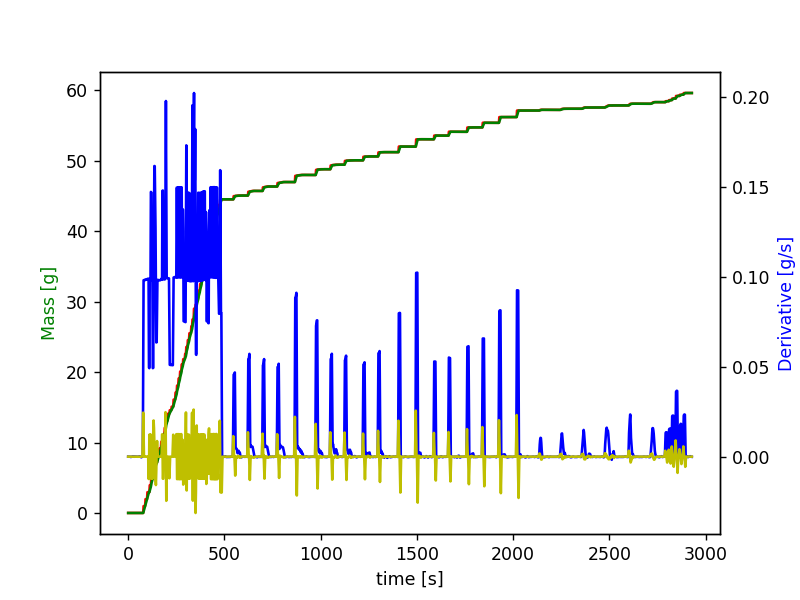

Addition of 0.542g Plantacare 818 detected from 542s to 588s - expected volume = 0.595mL and actual volume = 0.5mL (resulting error is 15.87%)
Addition of 0.66g Plantacare 818 detected from 618s to 660s - expected volume = 0.595mL and actual volume = 0.609mL (resulting error is 2.422%)
Addition of 0.628g Plantacare 818 detected from 694s to 736s - expected volume = 0.541mL and actual volume = 0.575mL (resulting error is 6.334%)
Addition of 0.638g Plantacare 818 detected from 770s to 818s - expected volume = 0.541mL and actual volume = 0.584mL (resulting error is 7.959%)
Addition of 1.011g Plantacare 818 detected from 862s to 914s - expected volume = 0.992mL and actual volume = 0.935mL (resulting error is 5.769%)
Addition of 0.816g Plantacare 2000 detected from 970s to 1014s - expected volume = 0.89mL and actual volume = 0.754mL (resulting error is 15.244%)
Addition of 0.651g Plantacare 2000 detected from 1046s to 1094s - expected volume = 0.536mL and actual volume = 0.602mL (resulting 

In [7]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.00125 g/s and for 2nd derivative = 0.000375 g/s^2


<IPython.core.display.Javascript object>


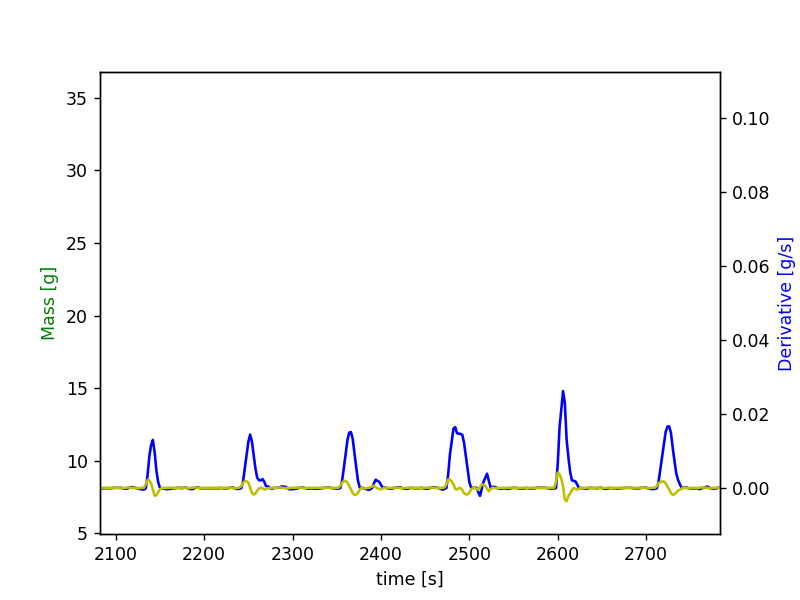

Addition of 0.101g Luviquat Excellence detected from 2132s to 2154s - expected volume = 0.11mL and actual volume = 0.091mL (resulting error is 17.581%)
Addition of 0.161g Luviquat Excellence detected from 2240s to 2272s - expected volume = 0.148mL and actual volume = 0.144mL (resulting error is 3.087%)
Addition of 0.189g Luviquat Excellence detected from 2352s to 2404s - expected volume = 0.166mL and actual volume = 0.173mL (resulting error is 4.052%)
Addition of 0.298g Luviquat Excellence detected from 2472s to 2528s - expected volume = 0.271mL and actual volume = 0.27mL (resulting error is 0.251%)
Addition of 0.249g Luviquat Excellence detected from 2596s to 2626s - expected volume = 0.226mL and actual volume = 0.227mL (resulting error is 0.353%)
Addition of 0.228g Luviquat Excellence detected from 2710s to 2742s - expected volume = 0.213mL and actual volume = 0.204mL (resulting error is 4.149%)


In [15]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=4, mergeSens=7, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


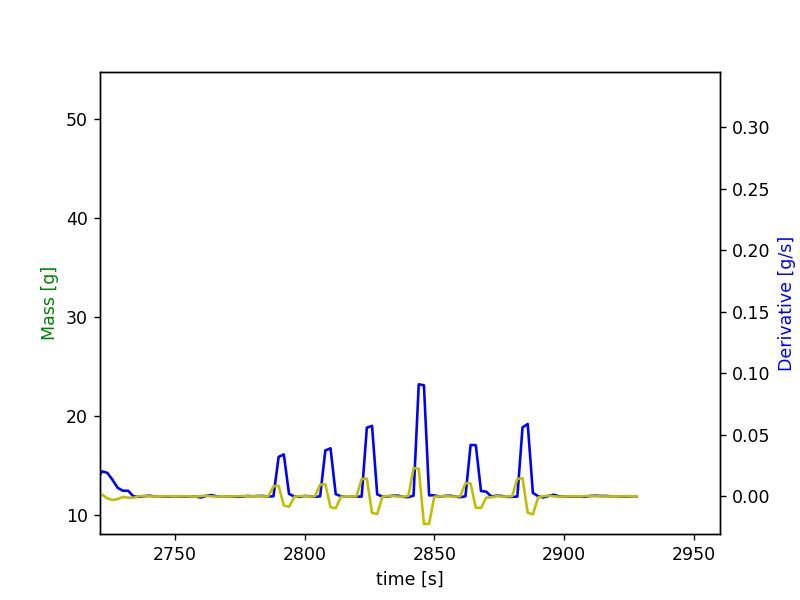

Addition of 0.135g Arlypon F detected from 2786s to 2798s - expected volume = 0.153mL and actual volume = 0.152mL (resulting error is 0.37%)
Addition of 0.155g Arlypon F detected from 2804s to 2816s - expected volume = 0.163mL and actual volume = 0.175mL (resulting error is 6.897%)
Addition of 0.227g Arlypon F detected from 2820s to 2832s - expected volume = 0.248mL and actual volume = 0.261mL (resulting error is 5.093%)
Addition of 0.363g Arlypon F detected from 2840s to 2852s - expected volume = 0.399mL and actual volume = 0.415mL (resulting error is 3.857%)
Addition of 0.181g Arlypon F detected from 2860s to 2874s - expected volume = 0.183mL and actual volume = 0.208mL (resulting error is 13.836%)
Addition of 0.23g Arlypon F detected from 2880s to 2892s - expected volume = 0.252mL and actual volume = 0.26mL (resulting error is 2.902%)


In [16]:
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=5, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

## Consolidate results and create output

In [17]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_040423_S271-S276.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_29308\3785407045.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
270,271.0,0.0,0.0,0.0,0.000000,0.000000,11.707312,0.000000,0.0,0.000000,0.0,0.0,12.844216,1.014557,0.0,0.0,0.0,1.346071,0.0
271,272.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,7.966325,0.0,0.000000,0.0,0.0,8.240096,1.607403,0.0,0.0,0.0,1.548702,0.0
272,273.0,0.0,0.0,0.0,12.067037,8.198032,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.902110,0.0,0.0,0.0,2.280021,0.0
273,274.0,0.0,0.0,0.0,12.395700,0.000000,0.000000,0.000000,0.0,10.549177,0.0,0.0,0.000000,2.921620,0.0,0.0,0.0,3.560800,0.0
274,275.0,0.0,0.0,0.0,9.863138,12.375014,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,2.427740,0.0,0.0,0.0,1.765629,0.0
275,276.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,10.334695,0.0,0.000000,0.0,0.0,9.280802,2.261706,0.0,0.0,0.0,2.285252,0.0
